In [48]:
!pip install wordcloud

In [49]:
!pip install -U spacy

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import TransformerMixin
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


In [51]:
df = pd.read_csv('fake_job_postings.csv.zip')
display(df.head())

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [52]:
df.shape

(17880, 18)

In [53]:
df.isnull().sum()

,0
job_id,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
telecommuting,0


In [54]:
columns=['telecommuting','has_company_logo','has_questions','employment_type','salary_range']
df = df.drop(columns=columns)

In [55]:
print(df.columns)

Index(['job_id', 'title', 'location', 'department', 'company_profile',
       'description', 'requirements', 'benefits', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent'],
      dtype='object')


In [56]:
display(df.head())

,job_id,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [57]:
df.fillna('',inplace=True)

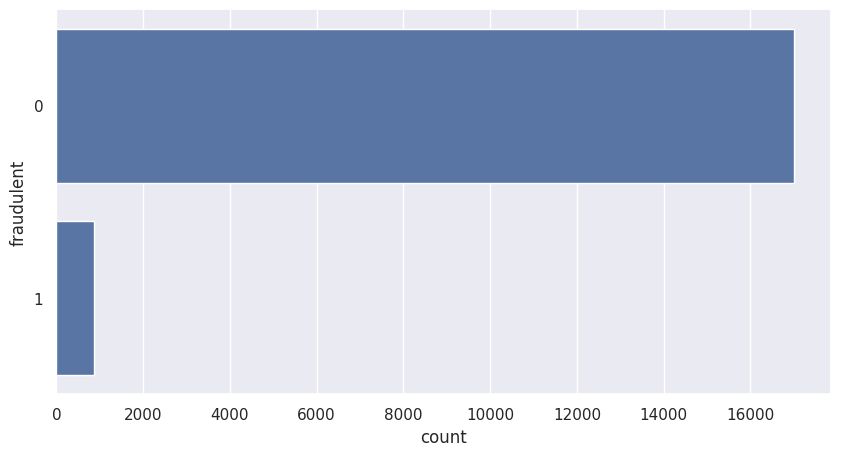

In [58]:
plt.figure(figsize=(10,5))
sns.countplot(y='fraudulent',data=df)
plt.show()

In [59]:
df.groupby('fraudulent')['fraudulent'].count()

,fraudulent
fraudulent,
0,17014
1,866


In [60]:
exp = dict(df.required_experience.value_counts())
del exp['']

In [61]:
exp

{'Mid-Senior level': np.int64(3809),
 'Entry level': np.int64(2697),
 'Associate': np.int64(2297),
 'Not Applicable': np.int64(1116),
 'Director': np.int64(389),
 'Internship': np.int64(381),
 'Executive': np.int64(141)}

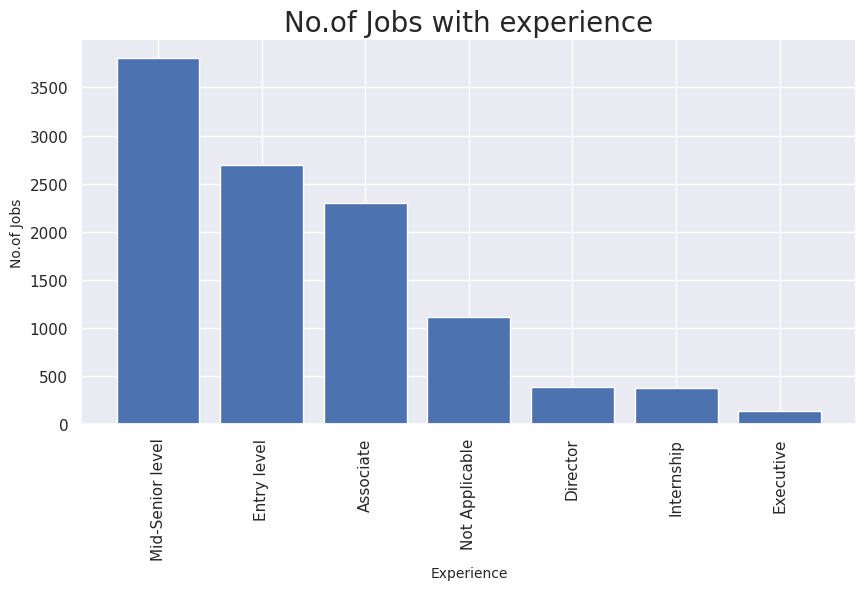

In [62]:
plt.figure(figsize=(10,5))
sns.set_theme(style='darkgrid')
plt.bar(exp.keys(),exp.values())
plt.title('No.of Jobs with experience', size=20)
plt.xlabel('Experience', size=10)
plt.ylabel('No.of Jobs', size=10)
plt.xticks(rotation=90)
plt.show()

In [63]:
def split_location(location):
  parts = location.split(',')
  return parts[0]

df['country'] = df['location'].apply(split_location)

In [64]:
df.head()

,job_id,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,1,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,5,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [65]:
country = dict(df.country.value_counts()[:14])
del country['']
country

{'US': np.int64(10656),
 'GB': np.int64(2384),
 'GR': np.int64(940),
 'CA': np.int64(457),
 'DE': np.int64(383),
 'NZ': np.int64(333),
 'IN': np.int64(276),
 'AU': np.int64(214),
 'PH': np.int64(132),
 'NL': np.int64(127),
 'BE': np.int64(117),
 'IE': np.int64(114),
 'SG': np.int64(80)}

In [66]:
country_display = {k: int(v) for k, v in country.items()}
print(country_display)

{'US': 10656, 'GB': 2384, 'GR': 940, 'CA': 457, 'DE': 383, 'NZ': 333, 'IN': 276, 'AU': 214, 'PH': 132, 'NL': 127, 'BE': 117, 'IE': 114, 'SG': 80}


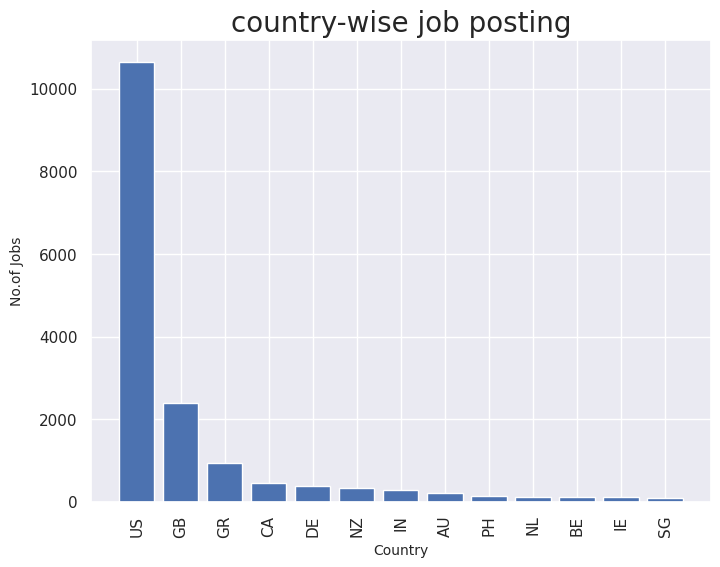

In [67]:
plt.figure(figsize=(8,6))
plt.title('country-wise job posting', size = 20)
plt.bar(country.keys(),country.values())
plt.ylabel('No.of Jobs', size = 10)
plt.xlabel('Country', size = 10)
plt.xticks(rotation=90)
plt.show()

In [68]:
education = dict(df.required_education.value_counts()[:7])
del education['']
education_display = {k: int(v) for k, v in education.items()}
print(education_display)

{"Bachelor's Degree": 5145, 'High School or equivalent': 2080, 'Unspecified': 1397, "Master's Degree": 416, 'Associate Degree': 274, 'Certification': 170}


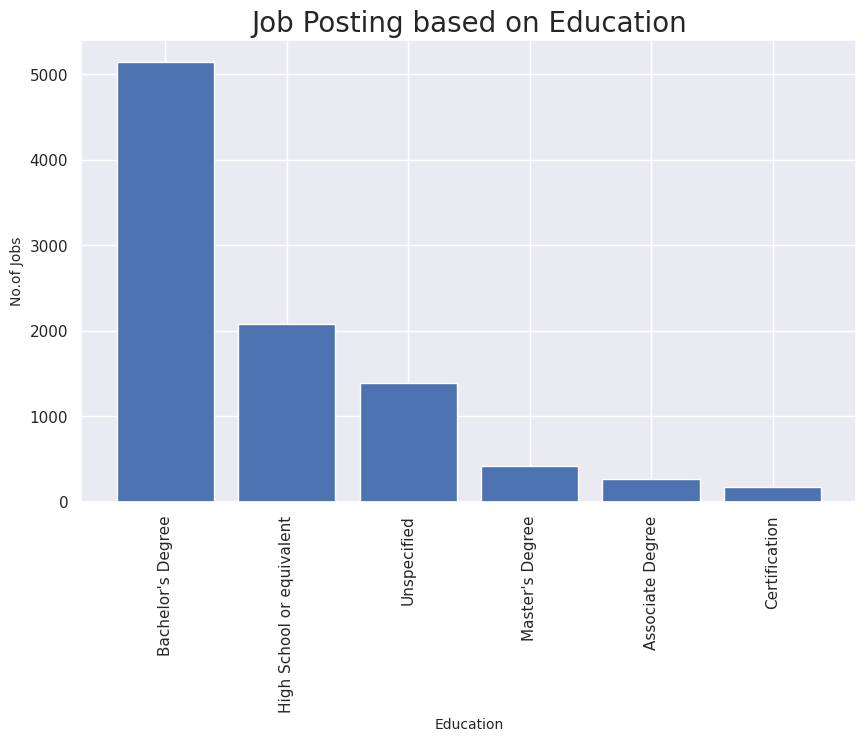

In [69]:
plt.figure(figsize=(10,6))
plt.title('Job Posting based on Education', size = 20)
plt.bar(education.keys(),education.values())
plt.ylabel('No.of Jobs', size = 10)
plt.xlabel('Education', size = 10)
plt.xticks(rotation=90)
plt.show()

In [70]:
print(df[df.fraudulent==0].title.value_counts()[:10])

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: count, dtype: int64


In [71]:
print(df[df.fraudulent==1].title.value_counts()[:10])

title
Data Entry Admin/Clerical Positions - Work From Home                    21
Cruise Staff Wanted *URGENT*                                            21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Network Marketing                                                       10
Payroll Clerk                                                           10
Name: count, dtype: int64


In [72]:
df['text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']
del df['job_id']




In [73]:
df.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [74]:
fraudjobs_text = df[df.fraudulent==1].text.values
realjobs_text = df[df.fraudulent==0].text.values

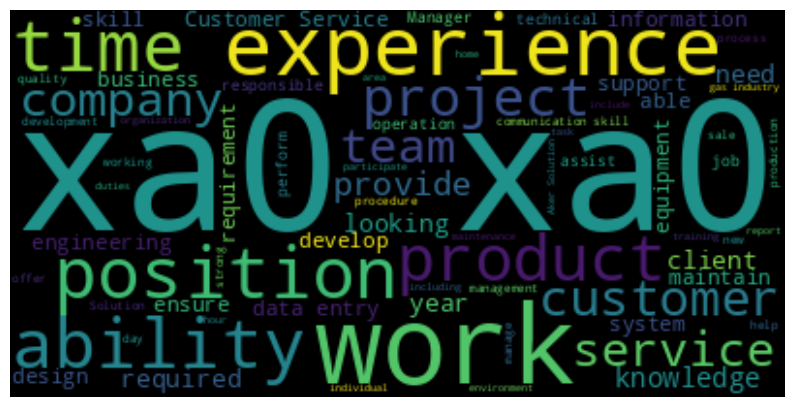

In [75]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(10,6))
wc = WordCloud(max_words=1000,min_font_size=5,max_font_size=100,background_color='black',stopwords=STOPWORDS).generate(str(fraudjobs_text))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

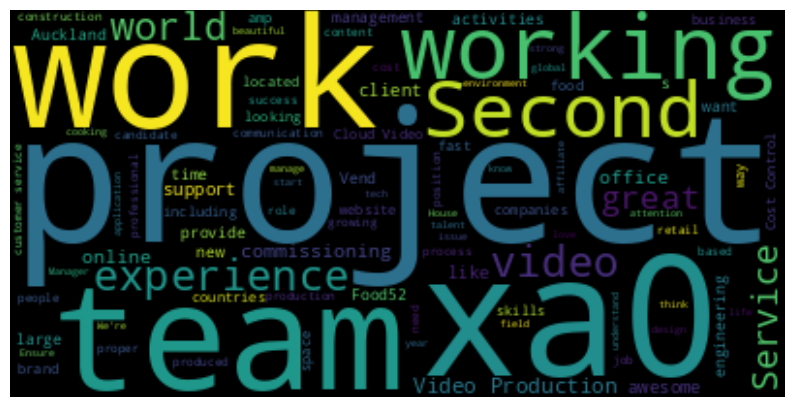

In [76]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(10,6))
wc = WordCloud(max_words=3000,min_font_size=5,max_font_size=100,background_color='black',stopwords=STOPWORDS).generate(str(realjobs_text))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

In [77]:
!pip install spacy && python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [78]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)

    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

def clean_text(text):
    return text.strip().lower()

In [79]:
df['text'] = df['text'].apply(clean_text)

In [80]:
cv = TfidfVectorizer(max_features=100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(),columns=cv.get_feature_names_out())
df.drop(["text"],axis=1,inplace=True)
df = pd.concat([df,df1],axis=1)

In [81]:
df.head()

,fraudulent,ability,about,all,also,amp,an,and,are,as,...,well,who,will,with,work,working,world,years,you,your
0,0,0.000000,0.041120,0.000000,0.042424,0.036488,0.000000,0.755238,0.000000,0.078653,...,0.040199,0.000000,0.000000,0.186067,0.051026,0.068029,0.000000,0.000000,0.000000,0.000000
1,0,0.021895,0.094183,0.035394,0.024292,0.041787,0.029771,0.490896,0.056626,0.060050,...,0.000000,0.000000,0.078004,0.165735,0.043827,0.116862,0.099327,0.000000,0.204854,0.130452
2,0,0.000000,0.000000,0.176807,0.000000,0.041749,0.089231,0.397029,0.113149,0.000000,...,0.000000,0.000000,0.062346,0.307512,0.058383,0.000000,0.000000,0.000000,0.094462,0.074476
3,0,0.023267,0.000000,0.018806,0.000000,0.000000,0.094909,0.695542,0.000000,0.031906,...,0.000000,0.023132,0.049735,0.075480,0.046573,0.000000,0.105551,0.019806,0.050236,0.059411
4,0,0.000000,0.000000,0.068009,0.000000,0.040147,0.028602,0.606379,0.081605,0.115386,...,0.044230,0.000000,0.000000,0.159230,0.028071,0.037425,0.000000,0.035814,0.030279,0.107427


In [82]:
y = df.iloc[:,0]
x = df.iloc[:,1:]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(12516, 100) (5364, 100) (12516,) (5364,)


In [83]:
print(y_train.head())
print(y_train.dtype)


1931     0
13451    0
14918    0
3538     0
14583    0
Name: fraudulent, dtype: int64
int64


In [84]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)


In [85]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model = rfc.fit(x_train,y_train)

In [86]:
print(x_test)

        ability     about       all      also       amp        an       and  \
8064   0.000000  0.000000  0.000000  0.000000  0.255024  0.000000  0.000000   
15155  0.038897  0.041830  0.031439  0.000000  0.296948  0.079334  0.186879   
1507   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.392615   
8666   0.096989  0.078227  0.039197  0.026902  0.000000  0.032969  0.569529   
2687   0.000000  0.000000  0.076718  0.052654  0.000000  0.064529  0.380014   
...         ...       ...       ...       ...       ...       ...       ...   
14353  0.018176  0.019547  0.044074  0.040333  0.034690  0.024714  0.533660   
17756  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3950   0.000000  0.000000  0.000000  0.000000  0.000000  0.042218  0.464097   
298    0.057167  0.061477  0.046206  0.000000  0.218209  0.038865  0.213619   
16246  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.442945   

            are        as        at  ...      well 

In [87]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
rfc.fit(x_train,y_train)
print(f"OOB Score: {rfc.oob_score_:.4f}")
y_pred = rfc.predict(x_test)
print(classification_report(y_test,y_pred))"""


'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import classification_report\nrfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")\nrfc.fit(x_train,y_train)\nprint(f"OOB Score: {rfc.oob_score_:.4f}")\ny_pred = rfc.predict(x_test)\nprint(classification_report(y_test,y_pred))'

In [88]:
print(x_test)

        ability     about       all      also       amp        an       and  \
8064   0.000000  0.000000  0.000000  0.000000  0.255024  0.000000  0.000000   
15155  0.038897  0.041830  0.031439  0.000000  0.296948  0.079334  0.186879   
1507   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.392615   
8666   0.096989  0.078227  0.039197  0.026902  0.000000  0.032969  0.569529   
2687   0.000000  0.000000  0.076718  0.052654  0.000000  0.064529  0.380014   
...         ...       ...       ...       ...       ...       ...       ...   
14353  0.018176  0.019547  0.044074  0.040333  0.034690  0.024714  0.533660   
17756  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3950   0.000000  0.000000  0.000000  0.000000  0.000000  0.042218  0.464097   
298    0.057167  0.061477  0.046206  0.000000  0.218209  0.038865  0.213619   
16246  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.442945   

            are        as        at  ...      well 

In [89]:
predictors = rfc.predict(x_test)
score = accuracy_score(y_test,predictors)
print(score)

0.9701715137956749


In [90]:
print("classification Report/n")
print(classification_report(y_test,predictors))
print("Confusion Matrix/n")
print(confusion_matrix(y_test,predictors))

classification Report/n
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5110
           1       0.99      0.37      0.54       254

    accuracy                           0.97      5364
   macro avg       0.98      0.69      0.76      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix/n
[[5109    1]
 [ 159   95]]
